In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.kps import KeypointsOnImage

import torch
import torch.nn as nn
from torch import optim

import torchvision.models as models

from tqdm.notebook import tqdm

In [2]:
DATA_PATH = '/home/xfs/Datasets/data/'
NUM_PTS = 971

SEED = 42

RESIZE_TO = 160
CROP_TO = 128
MEAN = np.array([0.4348, 0.3430, 0.3001])
STD = np.array([0.2966, 0.2491, 0.2298])

BATCH_SIZE = 128
NUM_WORKERS = 32

USE_CUDA = torch.cuda.is_available()

LR = 1e-3
EPOCHS_STAGE_1 = 20
EPOCHS_STAGE_2 = 4

MODEL_STAGE_1_SAVE_PATH = 'model_resnet34_stage_1.pth'
MODEL_STAGE_2_SAVE_PATH = 'model_resnet34_stage_2.pth'

FLIPPED_IDXS = (
    [i for i in range(64, 128)] +
    [i for i in range(0, 64)] +
    [i for i in range(272, 127, -1)] +
    [i for i in range(337, 401)] +
    [i for i in range(273, 337)] +
    [i for i in range(464, 527)] +
    [i for i in range(401, 464)] +
    [i for i in range(527, 587)] +
    [i for i in range(714, 841)] +
    [i for i in range(587, 714)] +
    [i for i in range(872, 840, -1)] +
    [i for i in range(904, 872, -1)] +
    [i for i in range(936, 904, -1)] +
    [i for i in range(968, 936, -1)] +
    [i for i in range(970, 971)] +
    [i for i in range(969, 970)]
)

SUBMISSION_NAME = 'submit_resnet34_stage_2.csv'
SUBMISSION_HEADER = 'file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n'

In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)

if USE_CUDA:
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [4]:
train_labels_df = pd.read_csv(
    os.path.join(os.path.join(DATA_PATH, 'train'), 'landmarks.csv'),
    delimiter='\t',
    dtype={
        f'Point_{i}_{axis}': np.int32 for axis in ['X', 'Y'] for i in range(NUM_PTS)
    }
)

test_df = pd.read_csv(
    os.path.join(os.path.join(DATA_PATH, 'test'), 'test_points.csv'),
    delimiter='\t'
)

# Augmentations

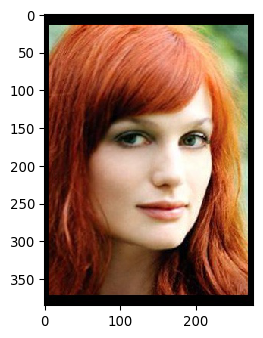

In [5]:
IDX = 0
image = imageio.imread(
    os.path.join(
        os.path.join(DATA_PATH, 'train'),
        f"images/{train_labels_df['file_name'][IDX]}"
    )
)
ia.imshow(image)

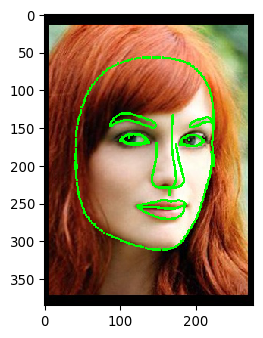

In [6]:
kps = train_labels_df.values[IDX, 1:].reshape(NUM_PTS, 2)
kpsoi = KeypointsOnImage.from_xy_array(kps, shape=image.shape)
ia.imshow(kpsoi.draw_on_image(image, size=2))

In [7]:
train_data_transforms = iaa.Sequential([
    iaa.PadToAspectRatio(1.0, position='center'),
    iaa.Resize({"height": RESIZE_TO, "width": RESIZE_TO}),
    iaa.Affine(
        scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        rotate=(-10, 10),
        shear=(-5, 5),
    ),
    iaa.CropToFixedSize(width=CROP_TO, height=CROP_TO, position='center')
])

valid_transforms = iaa.Sequential([
    iaa.PadToAspectRatio(1.0, position='center'),
    iaa.Resize({"height": RESIZE_TO, "width": RESIZE_TO}),
    iaa.CropToFixedSize(width=CROP_TO, height=CROP_TO, position='center')
])

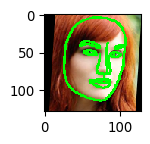

In [8]:
image_aug, kpsoi_aug = train_data_transforms(image=image, keypoints=kpsoi)
ia.imshow(kpsoi_aug.draw_on_image(image_aug, size=2))

# Dataset

In [9]:
class ThousandFacialLandmarksDataset(Dataset):
    def __init__(self, df, root, transforms, split):
        self.image_filenames = df['file_name'].values
        
        if split != 'test':
            self.landmarks = df.values[:, 1:].reshape(-1, NUM_PTS, 2)
        else:
            self.landmarks = None

        self.images_path = os.path.join(root, 'images')
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image = imageio.imread(os.path.join(self.images_path, self.image_filenames[idx]))
        
        if self.landmarks is None:
            h, w, _ = image.shape
            if self.transforms:
                image = self.transforms(image=image)
                image = (image / 255 - MEAN) / STD
                image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
                if h > w:
                    scale = RESIZE_TO / h
                    x_pad = (h - w) / 2
                    y_pad = 0
                else:
                    scale = RESIZE_TO / w
                    x_pad = 0
                    y_pad = (w - h) / 2
                    
            return {'image': image,
                    'paddings': np.array([x_pad, y_pad]),
                    'scale': scale
                   }

        kpsoi = KeypointsOnImage.from_xy_array(self.landmarks[idx], shape=image.shape)
        
        if self.transforms:
            image, kpsoi = self.transforms(image=image, keypoints=kpsoi)
            image = (image / 255 - MEAN) / STD
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {'image': image, 'landmarks': kpsoi.to_xy_array().flatten()}
    
    def __len__(self):
        return len(self.image_filenames)

In [10]:
train_df, valid_df = train_test_split(
    train_labels_df,
    test_size=0.2,
    shuffle=True,
    random_state=SEED
)

In [11]:
train_dataset = ThousandFacialLandmarksDataset(
    df=train_df,
    root=os.path.join(DATA_PATH, 'train'), 
    transforms=train_data_transforms,
    split='train'
)

valid_dataset = ThousandFacialLandmarksDataset(
    df=valid_df,
    root=os.path.join(DATA_PATH, 'train'), 
    transforms=valid_transforms,
    split='valid'
)

test_dataset = ThousandFacialLandmarksDataset(
    df=test_df,
    root=os.path.join(DATA_PATH, 'test'), 
    transforms=valid_transforms,
    split='test'
)

# Loaders

In [12]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=True
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# Model

In [13]:
device = torch.device('cuda:0') if USE_CUDA else torch.device('cpu')
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training
## Stage 1

In [14]:
optimizer = optim.Adam(model.parameters(), lr=LR, amsgrad=True)
criterion = nn.MSELoss(reduction='mean')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

In [15]:
best_valid_loss = float('inf')

avg_train_losses = []
avg_valid_losses = []

t_epochs = tqdm(range(EPOCHS_STAGE_1))

for i in t_epochs:
    # train
    model.train()
    avg_train_loss = 0
    
    t_train_loader = tqdm(
        train_loader,
        total=len(train_loader),
        desc='training...',
        leave=False
    )
    
    for batch in t_train_loader:
        images = batch['image'].to(device)
        landmarks = batch['landmarks']
        
        pred_landmarks = model(images).cpu()
        
        loss = criterion(pred_landmarks, landmarks)
        train_loss = loss.item()
        avg_train_loss += train_loss / len(train_loader)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        t_train_loader.set_postfix(train_loss=train_loss)

    avg_train_losses.append(avg_train_loss)
    
    # valid
    model.eval()
    avg_valid_loss = 0
    
    t_valid_loader = tqdm(
        valid_loader,
        total=len(valid_loader),
        desc='validation...',
        leave=False
    )
    
    for batch in t_valid_loader:
        images = batch['image'].to(device)
        landmarks = batch['landmarks']

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        
        loss = criterion(pred_landmarks, landmarks)
        valid_loss = loss.item()
        avg_valid_loss += valid_loss / len(valid_loader)
        
        t_valid_loader.set_postfix(valid_loss=valid_loss)

    avg_valid_losses.append(avg_valid_loss)
    
    # save checkpoint
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(model.state_dict(), MODEL_STAGE_1_SAVE_PATH)
        
    scheduler.step(avg_valid_loss)
    
    print('epoch: {:2} \t avg_train_loss: {:5.4} \t avg_valid_loss: {:5.4}'.format(
        i, avg_train_loss, avg_valid_loss
    ))

epoch:  0 	 avg_train_loss: 69.63 	 avg_valid_loss: 3.295


epoch:  1 	 avg_train_loss: 3.341 	 avg_valid_loss: 2.753


epoch:  2 	 avg_train_loss: 2.696 	 avg_valid_loss: 2.277


epoch:  3 	 avg_train_loss: 2.401 	 avg_valid_loss: 2.062


epoch:  4 	 avg_train_loss: 2.215 	 avg_valid_loss: 1.985


epoch:  5 	 avg_train_loss: 2.087 	 avg_valid_loss: 1.964


epoch:  6 	 avg_train_loss: 1.989 	 avg_valid_loss: 1.867


epoch:  7 	 avg_train_loss: 1.903 	 avg_valid_loss: 1.744


epoch:  8 	 avg_train_loss: 1.839 	 avg_valid_loss: 1.837


epoch:  9 	 avg_train_loss: 1.784 	 avg_valid_loss: 1.826


epoch: 10 	 avg_train_loss: 1.724 	 avg_valid_loss: 1.815


epoch: 11 	 avg_train_loss: 1.677 	 avg_valid_loss: 1.591


epoch: 12 	 avg_train_loss:   1.7 	 avg_valid_loss: 1.738


epoch: 13 	 avg_train_loss: 1.663 	 avg_valid_loss: 1.669


epoch: 14 	 avg_train_loss: 1.581 	 avg_valid_loss: 1.559


epoch: 15 	 avg_train_loss: 1.538 	 avg_valid_loss: 1.538


epoch: 16 	 avg_train_loss: 1.507 	 avg_valid_loss: 1.578


epoch: 17 	 avg_train_loss: 1.483 	 avg_valid_loss: 1.479


epoch: 18 	 avg_train_loss: 1.456 	 avg_valid_loss: 1.478


epoch: 19 	 avg_train_loss:  1.43 	 avg_valid_loss: 1.468



## Stage 2

In [16]:
# Датасет, в котором реализован флип по горизонтали
class ThousandFacialLandmarksFlipDataset(Dataset):
    def __init__(self, df, root, transforms, split):
        self.image_filenames = df['file_name'].values
        self.split = split
        
        if split != 'test':
            self.landmarks = df.values[:, 1:].reshape(-1, NUM_PTS, 2)
        else:
            self.landmarks = None

        self.images_path = os.path.join(root, 'images')
        self.transforms = transforms
        self.flip = iaa.Fliplr(1.0)
    
    def __getitem__(self, idx):
        image = imageio.imread(os.path.join(self.images_path, self.image_filenames[idx]))
        
        if self.landmarks is None:
            h, w, _ = image.shape
            if self.transforms:
                image = self.transforms(image=image)
                image = (image / 255 - MEAN) / STD
                image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
                if h > w:
                    scale = RESIZE_TO / h
                    x_pad = (h - w) / 2
                    y_pad = 0
                else:
                    scale = RESIZE_TO / w
                    x_pad = 0
                    y_pad = (w - h) / 2
                    
            return {'image': image,
                    'paddings': np.array([x_pad, y_pad]),
                    'scale': scale
                   }

        kpsoi = KeypointsOnImage.from_xy_array(self.landmarks[idx], shape=image.shape)
        
        kps = self.landmarks[idx]
        
        if self.transforms:
            use_flip = np.random.choice(2)
            if self.split == 'train' and use_flip:
                kps = kps[FLIPPED_IDXS]
                kpsoi = KeypointsOnImage.from_xy_array(kps, shape=image.shape)
                image, kpsoi = self.flip(image=image, keypoints=kpsoi)
            else:
                kpsoi = KeypointsOnImage.from_xy_array(kps, shape=image.shape)
            image, kpsoi = self.transforms(image=image, keypoints=kpsoi)
            image = (image / 255 - MEAN) / STD
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {'image': image, 'landmarks': kpsoi.to_xy_array().flatten()}
    
    def __len__(self):
        return len(self.image_filenames)
    
train_dataset = ThousandFacialLandmarksFlipDataset(
    df=train_df,
    root=os.path.join(DATA_PATH, 'train'), 
    transforms=train_data_transforms,
    split='train'
)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=True
)


model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)

model.load_state_dict(torch.load(MODEL_STAGE_1_SAVE_PATH))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR, amsgrad=True)
criterion = nn.MSELoss(reduction='mean')
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    LR,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS_STAGE_2
)

In [17]:
best_valid_loss = float('inf')

avg_train_losses = []
avg_valid_losses = []

t_epochs = tqdm(range(EPOCHS_STAGE_2))

for i in t_epochs:
    # train
    model.train()
    avg_train_loss = 0
    
    t_train_loader = tqdm(
        train_loader,
        total=len(train_loader),
        desc='training...',
        leave=False
    )
    
    for batch in t_train_loader:
        images = batch['image'].to(device)
        landmarks = batch['landmarks']
        
        pred_landmarks = model(images).cpu()
        
        loss = criterion(pred_landmarks, landmarks)
        train_loss = loss.item()
        avg_train_loss += train_loss / len(train_loader)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        t_train_loader.set_postfix(train_loss=train_loss)

    avg_train_losses.append(avg_train_loss)
    
    # valid
    model.eval()
    avg_valid_loss = 0
    
    t_valid_loader = tqdm(
        valid_loader,
        total=len(valid_loader),
        desc='validation...',
        leave=False
    )
    
    for batch in t_valid_loader:
        images = batch['image'].to(device)
        landmarks = batch['landmarks']

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        
        loss = criterion(pred_landmarks, landmarks)
        valid_loss = loss.item()
        avg_valid_loss += valid_loss / len(valid_loader)
        
        t_valid_loader.set_postfix(valid_loss=valid_loss)

    avg_valid_losses.append(avg_valid_loss)
    
    # save checkpoint
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(model.state_dict(), MODEL_STAGE_2_SAVE_PATH)
    
    print('epoch: {:2} \t avg_train_loss: {:5.4} \t avg_valid_loss: {:5.4}'.format(
        i, avg_train_loss, avg_valid_loss
    ))

epoch:  0 	 avg_train_loss: 1.529 	 avg_valid_loss: 2.274


epoch:  1 	 avg_train_loss: 1.683 	 avg_valid_loss: 2.318


epoch:  2 	 avg_train_loss: 1.439 	 avg_valid_loss:  1.39


epoch:  3 	 avg_train_loss: 1.294 	 avg_valid_loss:  1.39



In [18]:
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)

model.load_state_dict(torch.load(MODEL_STAGE_2_SAVE_PATH))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Inference

In [19]:
def restore_kps(xy_array, paddings, scale):
    return np.floor(
        (xy_array + (RESIZE_TO - CROP_TO) / 2) / scale - paddings + 0.5
    ).astype(int)

In [20]:
model.eval()

predictions = np.zeros((len(test_loader.dataset), NUM_PTS, 2))
for i, batch in enumerate(tqdm(test_loader, total=len(test_loader), desc="test prediction...")):
    images = batch["image"].to(device)

    with torch.no_grad():
        pred_landmarks = model(images).cpu()
    pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

    paddings = batch["paddings"].numpy()  # B x 2
    scale = batch["scale"].numpy()  # B
    prediction = restore_kps(
        pred_landmarks,
        paddings.reshape(-1, 1, 2),
        scale.reshape(-1, 1, 1)
    )
    predictions[i * test_loader.batch_size: (i + 1) * test_loader.batch_size] = prediction

In [21]:
def create_submission(test_predictions, path_to_submission_file):
    test_dir = os.path.join(DATA_PATH, "test")

    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(SUBMISSION_HEADER)

    mapping_path = os.path.join(test_dir, 'test_points.csv')
    mapping = pd.read_csv(mapping_path, delimiter='\t')

    for i, row in mapping.iterrows():
        file_name = row[0]
        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[i]
        needed_points = points_for_image[point_index_list].astype(np.int)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')

In [22]:
create_submission(predictions, SUBMISSION_NAME)

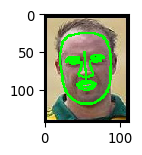

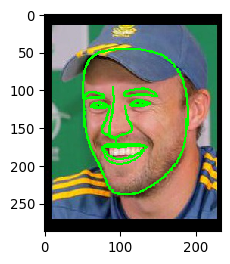

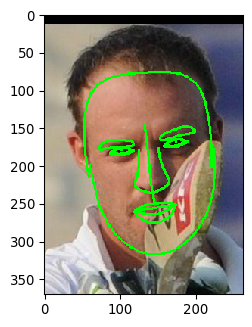

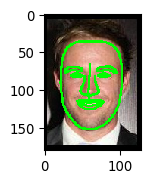

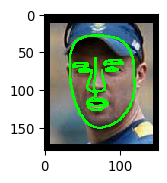

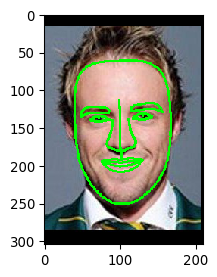

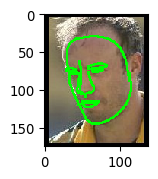

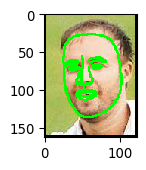

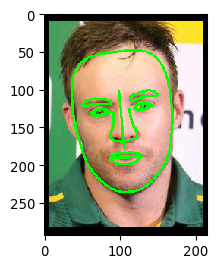

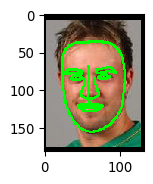

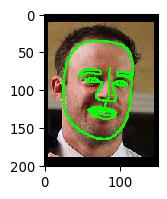

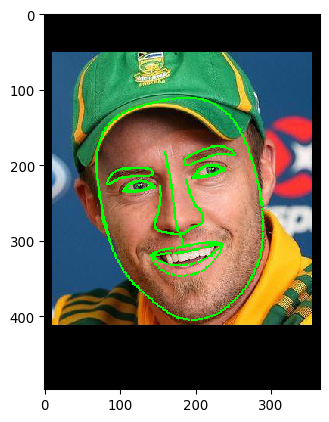

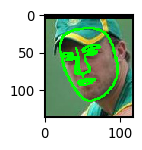

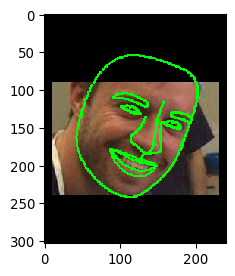

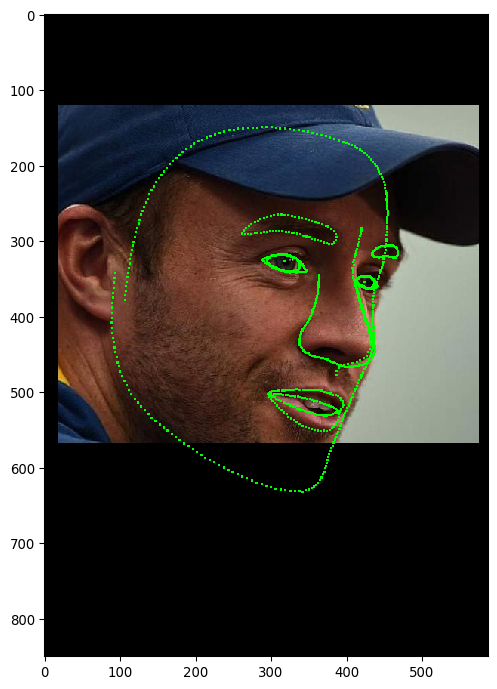

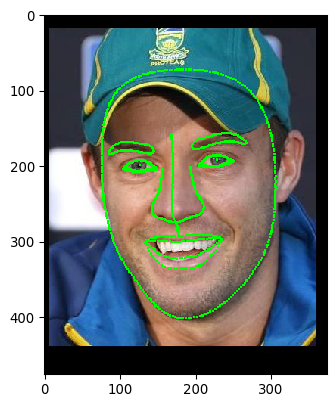

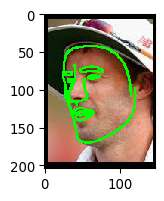

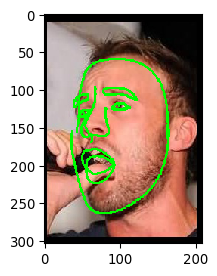

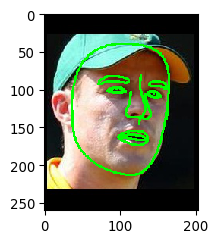

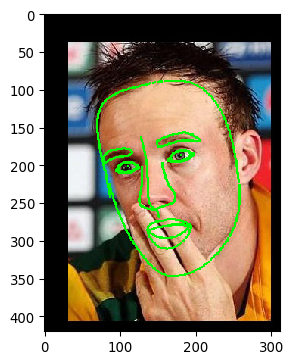

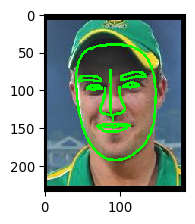

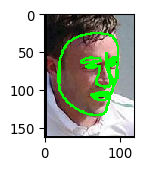

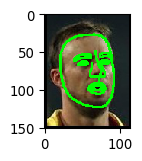

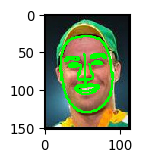

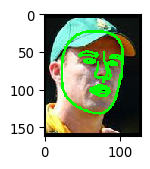

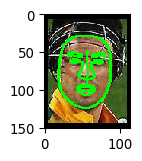

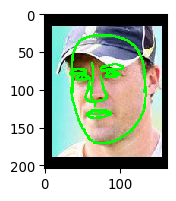

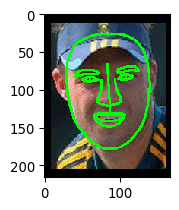

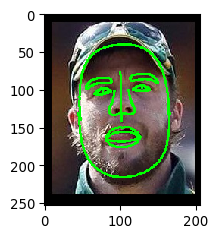

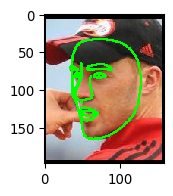

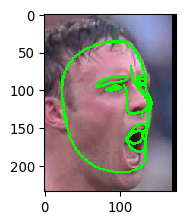

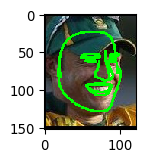

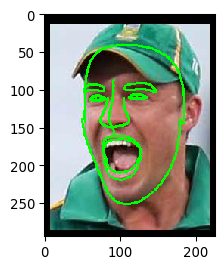

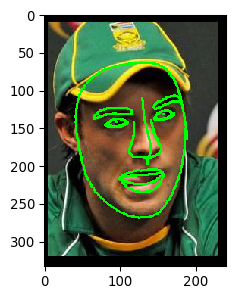

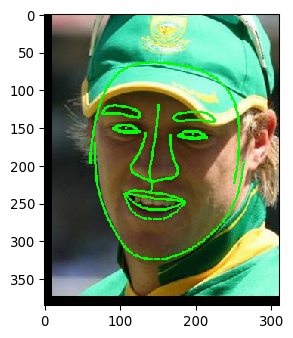

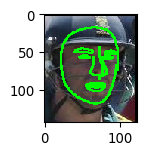

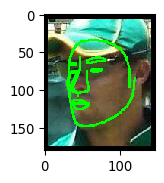

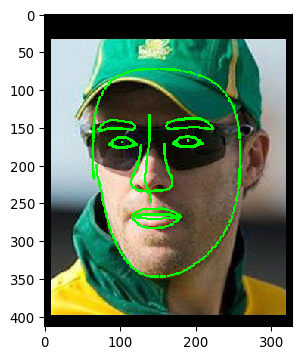

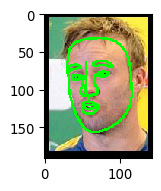

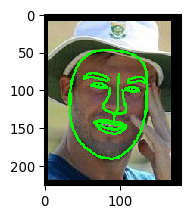

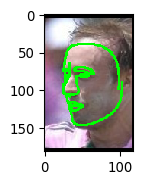

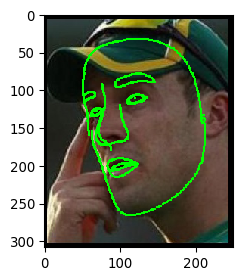

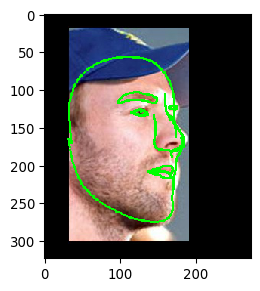

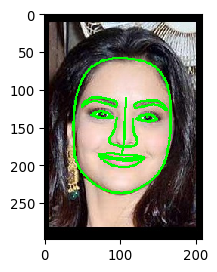

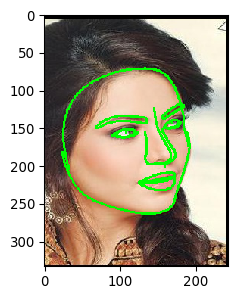

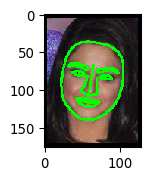

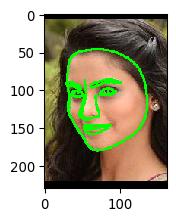

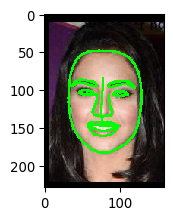

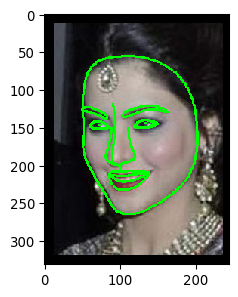

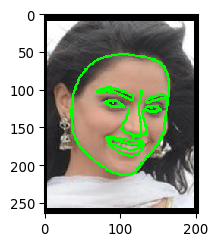

In [23]:
IMAGES_TO_SHOW = 50

for i in range(IMAGES_TO_SHOW):
    im = imageio.imread(os.path.join(os.path.join(DATA_PATH, 'test'), f"images/{test_df['file_name'].iloc[i]}"))
    kps = KeypointsOnImage.from_xy_array(predictions[i], shape=image.shape)
    ia.imshow(kps.draw_on_image(im, size=2))